## Sim Demo

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

  import numpy.matlib as npm

  autumn = cm.get_cmap('autumn', 256)

  winter = cm.get_cmap('winter_r', 256)



In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run) 

<module 'sim.sim_run' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim_run.py'>

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 7.1%
RAM Usage: 4.3%
Available RAM: 1.4T
Total RAM: 1.5T
52.4G


In [5]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


0
Available GPUs: 1
GPU 0: NVIDIA H100 80GB HBM3 - Memory Allocated: 0.00 GB


In [6]:
torch.cuda.is_available()

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

#### Simulation tests <a id="sims"></a>

Attention heads

In [7]:
from models.base_models import ModelBuild, BaseModel
from models.bilinear import BilinearLowRank, BilinearCM
from models.pls import PLSTwoStepModel, PLS_MLPDecoderModel, PLS_BilinearDecoderModel
from models.dynamic_mlp import DynamicMLP
from models.shared_encoder_models import SharedMLPEncoderModel, SharedLinearEncoderModel
from models.transformer_models import SharedSelfAttentionModel, SharedSelfAttentionCLSModel, CrossAttentionModel

from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_connectome, plot_transcriptome
from data.data_utils import expand_X_symmetric, expand_Y_symmetric

from data.data_utils import RegionPairDataset
from torch.utils.data import Subset

In [8]:
# Load data
print("Loading data...")
X = load_transcriptome(parcellation='S456', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate')
Y = load_connectome(dataset='UKBB', parcellation='S456', hemisphere='both', omit_subcortical=False)
coords = load_coords(parcellation='S456', hemisphere='both', omit_subcortical=False)
labels, network_labels = load_network_labels(parcellation='S456', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Create index map so we know true indices of valid data
valid_indices_values = np.where(valid_indices)[0]
valid2true_mapping = dict(enumerate(valid_indices_values))

# Subset all data using valid indices
X_valid = X[valid_indices]
Y_valid = Y[valid_indices][:, valid_indices]
coords_valid = coords[valid_indices]
labels = [labels[i] for i in range(len(labels)) if valid_indices[i]]
network_labels = network_labels[valid_indices]

# Create full region pair dataset
print("Creating RegionPairDataset...")
dataset = RegionPairDataset(
    X=X_valid,
    Y=Y_valid,
    coords=coords_valid,
    valid2true_mapping=valid2true_mapping, 
    dataset='UKBB', 
    parcellation='S456'
)

batch_size = 512

# Create global dataloader with all pairs
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True  # Speed up data transfer to GPU
)

# Create datasets for each subnetwork
unique_networks = np.unique(network_labels)
network_datasets = {}
print("Creating datasets for each subnetwork...")

for network in unique_networks:
    # Create mask for current network
    network_mask = network_labels == network
    
    # Subset data for this network
    X_network = X_valid[network_mask]
    Y_network = Y_valid[network_mask][:, network_mask]
    coords_network = coords_valid[network_mask]
    
    # Create mapping from network indices to true indices
    network_indices = np.where(network_mask)[0]
    network2true_mapping = {i: valid2true_mapping[idx] for i, idx in enumerate(network_indices)}
    
    # Create dataset for this network
    network_datasets[network] = RegionPairDataset(
        X=X_network,
        Y=Y_network, 
        coords=coords_network,
        valid2true_mapping=network2true_mapping, 
        dataset='UKBB', 
        parcellation='S456'
    )
    print(f"Network {network}: {len(network_datasets[network])} region pairs")

# Create dataloaders for each network
batch_size = 512
network_dataloaders = {
    network: DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    ) for network, dataset in network_datasets.items()
}


Loading data...
Creating RegionPairDataset...
Creating datasets for each subnetwork...
Network Cerebellum: 72 region pairs
Network Cont: 2652 region pairs
Network Default: 8190 region pairs
Network DorsAttn: 2070 region pairs
Network Limbic: 650 region pairs
Network SalVentAttn: 2162 region pairs
Network SomMot: 5852 region pairs
Network Subcortical: 2070 region pairs
Network Vis: 3660 region pairs


Load in model trained on best random train-test split

In [9]:
# from models.transformer_models import SharedSelfAttentionModel, SharedSelfAttentionCLSModel

# # Set up base model with the same hyperparameters used for training
# smt_base_model = SharedSelfAttentionModel(
#     input_dim=14760,   # should be 2 * num_genes
#     token_encoder_dim=20,
#     d_model=128,
#     encoder_output_dim=10,
#     nhead=4,
#     num_layers=4,
#     use_alibi=True,
#     dropout_rate=0.4,
#     transformer_dropout=0.4,
#     aug_prob=0.0,
#     deep_hidden_dims=[512, 256, 128],
#     binarize=False
# )

# # Load saved weights
# smt_base_model.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_base_seed9fold3.pt"))
# smt_base_model.eval()
# smt_base_model.to("cuda")

In [10]:
# UKBB
# predictions_ukbb_base, targets_ukbb_base = smt_base_model.predict(dataloader, 
#                                                                 collect_attn=True, 
#                                                                 save_attn_path='attn_base_SMT_UKBB_seed9fold3.npy')

### Evaluate attention heads

Token dim 20 

In [11]:
def create_gene_tokens(token_chunk_size=20):
    """
    Create gene tokens and chromosome switch points based on token chunk size
    
    Args:
        token_chunk_size (int): Number of genes per token
        
    Returns:
        gene_tokens (list): List of dictionaries containing token info
        chrom_switches (list): List of indices where chromosomes switch
    """
    # Get valid genes from load_transcriptome
    from data.data_load import load_transcriptome

    X, valid_genes = load_transcriptome(parcellation='S456', gene_list='0.2', dataset='AHBA', 
                                      run_PCA=False, omit_subcortical=False, hemisphere='both',
                                      impute_strategy='mirror_interpolate', sort_genes='refgenome', 
                                      return_valid_genes=True, null_model='none', random_seed=42)

    # Get reference genome info for valid genes
    refgenome = pd.read_csv('./data/enigma/gene_lists/human_refgenome_ordered.csv')

    valid_refgenome = refgenome[refgenome['gene_id'].isin(valid_genes)].drop_duplicates(subset='gene_id', keep='first')
    
    # Create gene groups/tokens
    num_tokens = len(valid_refgenome) // token_chunk_size
    
    gene_tokens = []

    for i in range(num_tokens):
        start_idx = i * token_chunk_size
        end_idx = start_idx + token_chunk_size
        token_genes = valid_refgenome.iloc[start_idx:end_idx]
        
        # Get unique chromosome for this token
        chrom = token_genes['chromosome'].iloc[0]
        
        token = {
            'token_id': i,
            'genes': token_genes['gene_id'].tolist(),
            'chromosome': chrom
        }
        gene_tokens.append(token)

    # Handle remaining genes if any
    remaining_genes = len(valid_refgenome) % token_chunk_size
    if remaining_genes > 0:
        start_idx = num_tokens * token_chunk_size
        token_genes = valid_refgenome.iloc[start_idx:]
        token = {
            'token_id': num_tokens,
            'genes': token_genes['gene_id'].tolist(), 
            'chromosome': token_genes['chromosome'].iloc[0]
        }
        gene_tokens.append(token)
    # Get chromosome switch points
    chrom_switches = []
    for i in range(1, len(gene_tokens)):
        if gene_tokens[i]['chromosome'] != gene_tokens[i-1]['chromosome']:
            chrom_switches.append(i)
    
    # Print token and switch point info
    print(f"Number of tokens: {len(gene_tokens)}")
    print(f"Number of chromosome switch points: {len(chrom_switches)}")
    print("Example token:")
    print(gene_tokens[0])
    # Print chromosome switches to validate
    print("Chromosome switch points:")
    for i in chrom_switches:
        print(f"Switch at token {i}: {gene_tokens[i-1]['chromosome']} -> {gene_tokens[i]['chromosome']}")
    print('\n')
    return gene_tokens, chrom_switches

gene_tokens_20, chrom_switches_20 = create_gene_tokens(token_chunk_size=20)
gene_tokens_60, chrom_switches_60 = create_gene_tokens(token_chunk_size=60)

valid genes ['LOC729737', 'LINC01128', 'SAMD11', 'PERM1', 'HES4', 'ISG15', 'AGRN', 'TNFRSF4', 'B3GALT6', 'ACAP3', 'PUSL1', 'DVL1', 'MXRA8', 'CCNL2', 'ANKRD65', 'FNDC10', 'CDK11A', 'GABRD', 'RER1', 'PEX10', 'PLCH2', 'HES5', 'TNFRSF14', 'ARHGEF16', 'TPRG1L', 'AJAP1', 'TNFRSF25', 'PLEKHG5', 'NOL9', 'PHF13', 'CAMTA1', 'PER3', 'ERRFI1', 'SLC45A1', 'ENO1', 'SLC2A5', 'SPSB1', 'TMEM201', 'PIK3CD', 'CLSTN1', 'CTNNBIP1', 'UBE4B', 'PGD', 'TARDBP', 'MASP2', 'SRM', 'FBXO2', 'FBXO44', 'DRAXIN', 'CLCN6', 'NPPA', 'NPPB', 'VPS13D', 'DHRS3', 'LRRC38', 'PDPN', 'PRDM2', 'KAZN', 'EFHD2', 'AGMAT', 'PLEKHM2', 'SLC25A34', 'UQCRHL', 'SRARP', 'SZRD1', 'CROCCP2', 'SDHB', 'RCC2', 'ARHGEF10L', 'IGSF21', 'ALDH4A1', 'IFFO2', 'MRTO4', 'AKR7L', 'AKR7A3', 'AKR7A2', 'CAPZB', 'UBXN10', 'CAMK2N1', 'FAM43B', 'PINK1', 'KIF17', 'SH2D5', 'NBPF3', 'ALPL', 'RAP1GAP', 'CDC42', 'WNT4', 'ZBTB40', 'C1QA', 'C1QC', 'C1QB', 'EPHB2', 'LUZP1', 'ZNF436', 'ZNF436-AS1', 'TCEA3', 'ASAP3', 'HMGCL', 'IFNLR1', 'STPG1', 'NIPAL3', 'RCAN3', 'SYF2

In [12]:
gene_tokens_60

[{'token_id': 0,
  'genes': ['LOC729737',
   'LINC01128',
   'SAMD11',
   'PERM1',
   'HES4',
   'ISG15',
   'AGRN',
   'TNFRSF4',
   'B3GALT6',
   'ACAP3',
   'PUSL1',
   'DVL1',
   'MXRA8',
   'CCNL2',
   'ANKRD65',
   'FNDC10',
   'CDK11A',
   'GABRD',
   'RER1',
   'PEX10',
   'PLCH2',
   'HES5',
   'TNFRSF14',
   'ARHGEF16',
   'TPRG1L',
   'AJAP1',
   'CHD5',
   'TNFRSF25',
   'PLEKHG5',
   'NOL9',
   'PHF13',
   'CAMTA1',
   'PER3',
   'ERRFI1',
   'SLC45A1',
   'ENO1',
   'SLC2A5',
   'SPSB1',
   'TMEM201',
   'PIK3CD',
   'CLSTN1',
   'CTNNBIP1',
   'UBE4B',
   'PGD',
   'TARDBP',
   'MASP2',
   'SRM',
   'FBXO2',
   'FBXO44',
   'DRAXIN',
   'CLCN6',
   'NPPA',
   'NPPB',
   'VPS13D',
   'DHRS3',
   'LRRC38',
   'PDPN',
   'PRDM2',
   'KAZN',
   'EFHD2'],
  'chromosome': 'NC_000001.11'},
 {'token_id': 1,
  'genes': ['AGMAT',
   'PLEKHM2',
   'SLC25A34',
   'UQCRHL',
   'SRARP',
   'SZRD1',
   'CROCCP2',
   'SDHB',
   'RCC2',
   'ARHGEF10L',
   'IGSF21',
   'ALDH4A1',
   'IFFO

Plotting functionality for attention head exploration

In [13]:
# Global font size parameter
FONTSIZE = 24

def plot_all_attention_heads(attn_weights, chrom_switches):
    '''
    Plot individual attention weights for each head plus average in a single row
    '''
    num_heads = attn_weights.shape[0]
    #chrom_switches = chrom_switches[:-1]
    # Create a figure with num_heads + 1 subplots in a single row (extra one for average)
    fig, axes = plt.subplots(1, num_heads + 1, figsize=(25, 6))
    
    # Plot individual heads
    for head in range(num_heads):
        vmin, vmax = attn_weights[head].min(), attn_weights[head].max()
        im = axes[head].imshow(attn_weights[head], cmap="viridis", vmin=vmin, vmax=vmax)
        axes[head].set_title(f"Head {head+1}", fontsize=FONTSIZE+2)
        if head == 0:  # Only add labels for first plot
            axes[head].set_xlabel("Key", fontsize=FONTSIZE)
            axes[head].set_ylabel("Query", fontsize=FONTSIZE)
        # Add chromosome switch points as ticks
        axes[head].set_xticks(chrom_switches)
        axes[head].set_yticks(chrom_switches)
        axes[head].tick_params(axis='both', which='major', labelsize=FONTSIZE-10)
        axes[head].tick_params(axis='x', rotation=90)
    
    # Plot average head
    avg_head = attn_weights.mean(axis=0)
    vmin, vmax = avg_head.min(), avg_head.max()
    im = axes[-1].imshow(avg_head, cmap="viridis", vmin=vmin, vmax=vmax)
    axes[-1].set_title("Average", fontsize=FONTSIZE+2)
    axes[-1].set_xticks(chrom_switches)
    axes[-1].set_yticks(chrom_switches)
    axes[-1].tick_params(axis='both', which='major', labelsize=FONTSIZE-8)
    axes[-1].tick_params(axis='x', rotation=90)
    
    plt.tight_layout()
    plt.show()

    # Plot colorbar separately
    # fig_cbar = plt.figure(figsize=(2, 6))
    # cbar = plt.colorbar(im, cax=plt.gca(), label=f"[{vmin:.2f}, {vmax:.2f}]")
    # cbar.ax.tick_params(labelsize=FONTSIZE-4)
    # cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    # plt.show()

def plot_average_head(avg_attn, chrom_switches, vectorize=False):
    '''
    Plot average attention weights across all heads
    If vectorize=True, return columnwise mean of average attention
    '''
    
    # Average across all heads
    avg_head = avg_attn.mean(axis=0)
    #chrom_switches = chrom_switches[:-1]

    plt.figure(figsize=(8, 7))
    vmin, vmax = avg_head.min(), avg_head.max()
    im = plt.imshow(avg_head, cmap="viridis", vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, label=f"[{vmin:.2f}, {vmax:.2f}]", shrink=0.3)
    cbar.ax.tick_params(labelsize=FONTSIZE)
    cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    plt.title("Average Attention Across All Heads", fontsize=FONTSIZE+2)
    plt.xlabel("Key", fontsize=FONTSIZE)
    plt.ylabel("Query", fontsize=FONTSIZE)
    plt.xticks(chrom_switches, fontsize=FONTSIZE-6, rotation=90)
    plt.yticks(chrom_switches, fontsize=FONTSIZE-6)
    plt.show()

    if vectorize:
        return avg_head.sum(axis=0)
    return avg_head


def plot_all_attention_heads_true_ticks(attn_weights, chrom_switches):
    '''
    Plot individual attention weights for each head plus average in a single row
    '''
    num_heads = attn_weights.shape[0]
    max_idx = attn_weights.shape[1]
    tick_indices = list(range(0, max_idx, 5))
    #chrom_switches = chrom_switches[:-1]

    # Create a figure with num_heads + 1 subplots in a single row (extra one for average)
    fig, axes = plt.subplots(1, num_heads + 1, figsize=(25, 6))
    
    # Plot individual heads
    for head in range(num_heads):
        vmin, vmax = attn_weights[head].min(), attn_weights[head].max()
        im = axes[head].imshow(attn_weights[head], cmap="viridis", vmin=vmin, vmax=vmax)
        axes[head].set_title(f"Head {head+1}", fontsize=FONTSIZE+2)
        axes[head].set_xlabel("Key", fontsize=FONTSIZE)
        axes[head].set_ylabel("Query", fontsize=FONTSIZE)
        # Add indices as ticks with smaller font
        axes[head].set_xticks(tick_indices)
        axes[head].set_yticks(tick_indices)
        axes[head].tick_params(axis='both', which='major', labelsize=6)
        cbar = fig.colorbar(im, ax=axes[head], label=f"[{vmin:.2f}, {vmax:.2f}]", shrink=0.3)
        cbar.ax.tick_params(labelsize=FONTSIZE-8)
        cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    
    # Plot average head
    avg_head = attn_weights.mean(axis=0)
    vmin, vmax = avg_head.min(), avg_head.max()
    im = axes[-1].imshow(avg_head, cmap="viridis", vmin=vmin, vmax=vmax)
    axes[-1].set_title("Average", fontsize=FONTSIZE+2)
    axes[-1].set_xlabel("Key", fontsize=FONTSIZE)
    axes[-1].set_ylabel("Query", fontsize=FONTSIZE)
    axes[-1].set_xticks(tick_indices)
    axes[-1].set_yticks(tick_indices)
    axes[-1].tick_params(axis='both', which='major', labelsize=6)
    cbar = fig.colorbar(im, ax=axes[-1], label=f"[{vmin:.2f}, {vmax:.2f}]", shrink=0.3)
    cbar.ax.tick_params(labelsize=FONTSIZE-8)
    cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    
    plt.tight_layout()
    plt.show()

def create_gene_attention_df(gene_tokens, summed_attention_vec):
    """
    Create a dataframe mapping genes to their attention scores.
    
    Args:
        gene_tokens (list): List of dictionaries containing gene information per token
        summed_attention_vec (np.array): Vector of attention scores for each token
        
    Returns:
        pd.DataFrame: DataFrame with columns 'Gene' and 'Attention_Score'
    """
    # Add attention scores to gene tokens
    for i, token in enumerate(gene_tokens):
        token['attention_score'] = summed_attention_vec[i]
        
    # Create lists to store gene IDs and their attention scores
    genes = []
    attention_scores = []
    
    # Iterate through tokens and extract gene-attention pairs
    for token in gene_tokens:
        # Each gene in the token gets the same attention score
        for gene in token['genes']:
            genes.append(gene)
            attention_scores.append(token['attention_score'])
            
    # Create and return dataframe
    gene_attention_df = pd.DataFrame({
        'Gene': genes,
        'Attention_Score': attention_scores
    })
    
    return gene_attention_df

UKBB Model Attention:


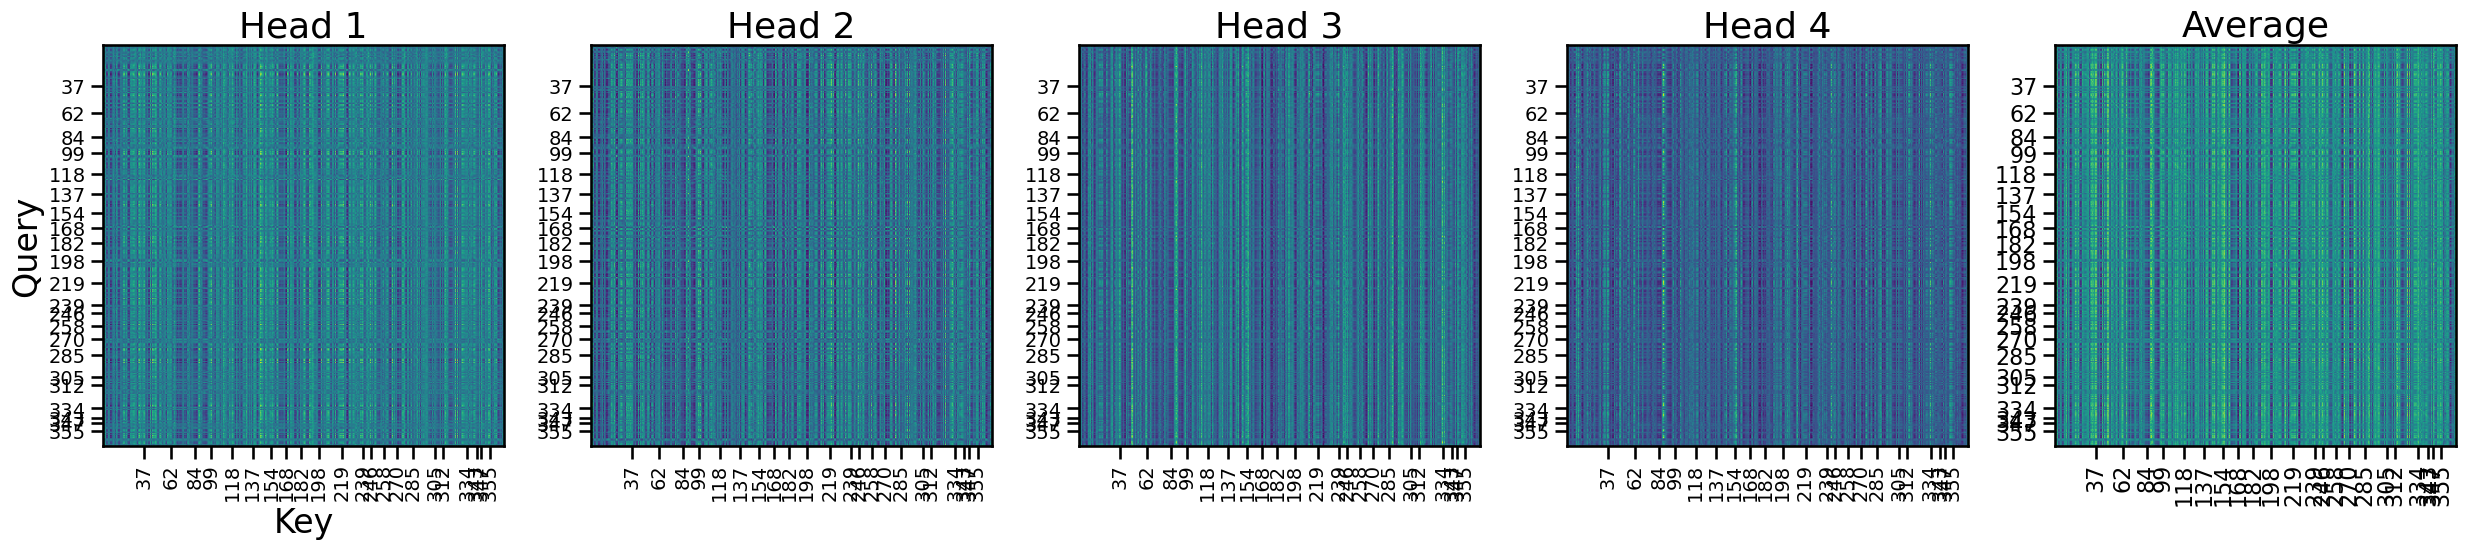

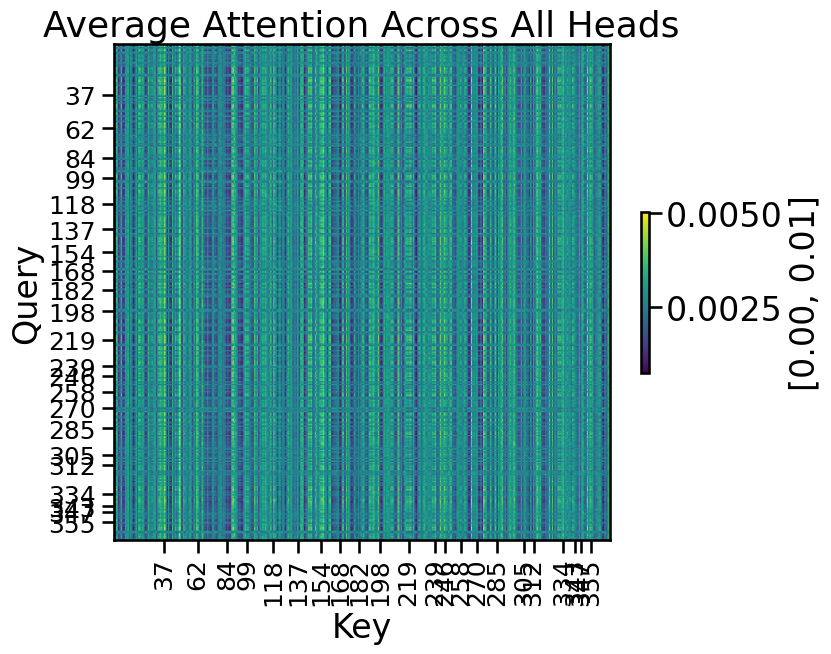

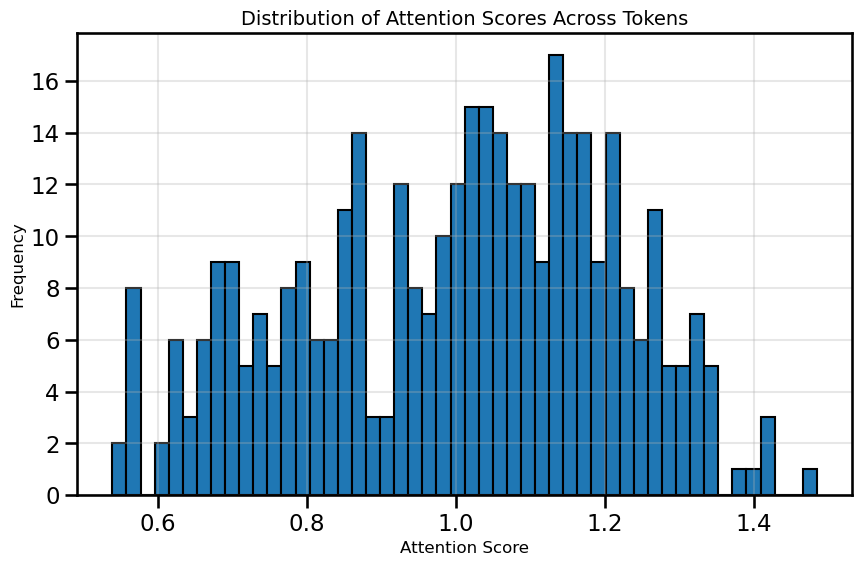

In [14]:
# Load if already computed
avg_base_smt_20dim_attn_ukbb = np.load('./notebooks/NeurIPS/attn_heads/attn_base_SMT_UKBB_seed9fold3.npy')

# Plot attention weights for UKBB model
print("UKBB Model Attention:")
plot_all_attention_heads(avg_base_smt_20dim_attn_ukbb, chrom_switches_20)

summed_attention_20_vec = plot_average_head(avg_base_smt_20dim_attn_ukbb, chrom_switches_20, vectorize=True)

plt.figure(figsize=(10,6))
plt.hist(summed_attention_20_vec, bins=50, edgecolor='black')
plt.xlabel('Attention Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Attention Scores Across Tokens', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()


In [32]:
gene_attention_20_df = create_gene_attention_df(gene_tokens_20, summed_attention_20_vec)
print("Created gene-attention dataframe with shape:", gene_attention_20_df.shape)
gene_attention_20_df.head()

gene_attention_20_df.to_csv('gene_attention_20_dim.csv', index=False)

Created gene-attention dataframe with shape: (7380, 2)


GSEA

In [33]:
gene_attention_20_df = gene_attention_20_df.sort_values('Attention_Score', ascending=False)
# write without header
gene_attention_20_df[['Gene','Attention_Score']].to_csv(f'gene_attention_20_dim.rnk',
                                                   sep='\t', index=False,
                                                   header=False)
pre_res = gp.prerank(
    rnk='gene_attention.rnk',
    gene_sets='KEGG_2021_Human',
    min_size=15,              # Minimum gene set size
    max_size=60,             # Maximum gene set size
    permutation_num=1000,     # Number of permutations
    weight=1,                 # Weight for ranking
    ascending=False,          # Sort descending
    threads=4,                # Number of threads
    figsize=[6.5,6],         # Figure size
    outdir=None,             # Don't write files
    format='pdf',            # Figure format
    graph_num=20,            # Plot top 20 enriched sets
    no_plot=False,           # Generate plots
    seed=42,                 # Random seed
    verbose=True             # Print progress
)

pre_res.res2d.head(20)

Exception: Error parsing expression values!

In [ ]:
from gseapy.plot import dotplot

ax = dotplot(
    df=pre_res.res2d,
    title='GSEA: Enriched Pathways (Attention‑ranked genes)',
    column='NOM p-val',  # Default column name for FDR values
    x='NES',                   # x-axis = normalized enrichment score 
    y='Term',                  # y-axis = pathway names
    cutoff=0.1,              # Only show terms with adj p-value < 0.05
    top_term=15,              # Show top 15 enriched terms
    size=10,                  # Base dot size
    figsize=(6,8),
    cmap='RdYlBu_r',         # Red-Yellow-Blue colormap (reversed)
    xticklabels_rot=45,      # Rotate x-axis labels 45 degrees
    marker='o'               # Use circular markers
)
ax.figure.tight_layout()
# ax.figure.savefig('gsea_dotplot.pdf', dpi=300)

Token dim 60 

In [ ]:
avg_base_smt_60dim_attn_ukbb = np.load('./notebooks/NeurIPS/attn_heads/attn_base_SMT_full_training.npy')
summed_attention_60_vec = plot_average_head(avg_base_smt_60dim_attn_ukbb, chrom_switches_60, vectorize=True)

# Usage
gene_attention_60_df = create_gene_attention_df(gene_tokens_60, summed_attention_60_vec)
print("Created gene-attention dataframe with shape:", gene_attention_60_df.shape)
gene_attention_60_df.head()

In [ ]:
import gseapy as gp

gene_attention_60_df = gene_attention_60_df.sort_values('Attention_Score', ascending=False)

# write without header
gene_attention_60_df[['Gene','Attention_Score']].to_csv(f'gene_attention_60_dim.rnk',
                                                   sep='\t', index=False,
                                                   header=False)

pre_res = gp.prerank(
    rnk='gene_attention.rnk',
    gene_sets='KEGG_2021_Human',
    min_size=15,              # Minimum gene set size
    max_size=7380,             # Maximum gene set size
    permutation_num=1000,     # Number of permutations
    weight=1,                 # Weight for ranking
    ascending=False,          # Sort descending
    threads=4,                # Number of threads
    figsize=[6.5,6],         # Figure size
    outdir=None,             # Don't write files
    format='pdf',            # Figure format
    graph_num=20,            # Plot top 20 enriched sets
    no_plot=False,           # Generate plots
    seed=42,                 # Random seed
    verbose=True             # Print progress
)

pre_res.res2d.head(20)

In [ ]:
ax = dotplot(
    df=pre_res.res2d,
    title='GSEA: Enriched Pathways (Attention‑ranked genes)',
    column='FWER p-val',  # Default column name for FDR values
    x='NES',                   # x-axis = normalized enrichment score 
    y='Term',                  # y-axis = pathway names
    cutoff=0.5,              # Only show terms with adj p-value < 0.05
    top_term=15,              # Show top 15 enriched terms
    size=10,                  # Base dot size
    figsize=(6,8),
    cmap='RdYlBu_r',         # Red-Yellow-Blue colormap (reversed)
    xticklabels_rot=45,      # Rotate x-axis labels 45 degrees
    marker='o'               # Use circular markers
)
ax.figure.tight_layout()
# ax.figure.savefig('gsea_dotplot.pdf', dpi=300)

Token list grabber

In [20]:
gene_attention_60_df

NameError: name 'gene_attention_60_df' is not defined

In [ ]:
print(" ".join(gene_attention_60_df.head(3*60)['Gene'].tolist()))

In [ ]:
gene_attention_20_df

In [ ]:
print(" ".join(gene_attention_20_df.head(10*20)['Gene'].tolist()))

Manual grab

In [28]:
gene_tokens_60[106]

{'token_id': 106,
 'genes': ['NANOS3',
  'C19orf57',
  'DDX39A',
  'DNAJB1',
  'ZNF333',
  'AKAP8',
  'WIZ',
  'RASAL3',
  'RAB8A',
  'FAM32A',
  'AP1M1',
  'KLF2',
  'TMEM38A',
  'NWD1',
  'SIN3B',
  'CPAMD8',
  'HAUS8',
  'OCEL1',
  'BABAM1',
  'ABHD8',
  'MRPL34',
  'DDA1',
  'UNC13A',
  'CCDC124',
  'KCNN1',
  'MAST3',
  'IFI30',
  'MPV17L2',
  'IQCN',
  'LSM4',
  'ISYNA1',
  'ELL',
  'KXD1',
  'UBA52',
  'CRLF1',
  'TMEM59L',
  'COMP',
  'CERS1',
  'HOMER3',
  'SUGP2',
  'RFXANK',
  'NR2C2AP',
  'NCAN',
  'HAPLN4',
  'GATAD2A',
  'YJEFN3',
  'PBX4',
  'GMIP',
  'ZNF714',
  'ZNF493',
  'ZNF429',
  'IPO5P1',
  'ZNF681',
  'ZNF254',
  'UQCRFS1',
  'POP4',
  'PLEKHF1',
  'C19orf12',
  'CCNE1',
  'URI1'],
 'chromosome': 'NC_000019.10'}

In [16]:
print(" ".join(gene_tokens_60[60]['genes']))
print(" ".join(gene_tokens_60[82]['genes']))
print(" ".join(gene_tokens_60[106]['genes']))

SLC2A6 ADAMTSL2 FAM163B SARDH VAV2 RXRA COL5A1 OLFM1 PPP1R26 C9orf116 SOHLH1 KCNT1 NACC2 TMEM250 GPSM1 CARD9 PMPCA SEC16A EGFL7 SNHG7 LCN15 TMEM141 PHPT1 FBXW5 NPDC1 SAPCD2 MAN1B1-AS1 DPP7 TMEM203 RNF208 TUBB4B NRARP EXD3 NSMF PNPLA7 EHMT1 TUBB8 ZMYND11 IDI2-AS1 IDI1 WDR37 ADARB2-AS1 PFKP PITRM1 LOC105376360 KLF6 AKR1C1 AKR1C3 AKR1C4 CALML3 ASB13 ANKRD16 PFKFB3 PRKCQ-AS1 SFMBT2 ITIH5 TAF3 CELF2 USP6NL ECHDC3
PNP RNASE6 METTL17 NDRG2 ARHGEF40 ZNF219 HNRNPC RAB2B TOX4 SALL2 DAD1 ABHD4 OXA1L SLC7A7 PRMT5 HAUS4 PSMB5 C14orf119 SLC7A8 HOMEZ PPP1R3E BCL2L2 MYH7 THTPA ZFHX2 AP1G2 JPH4 DHRS2 DHRS4 CARMIL3 CPNE6 PCK2 DCAF11 PSME1 PSME2 RNF31 CHMP4A NEDD8 GMPR2 TGM1 RABGGTA STXBP6 NOVA1 FOXG1 LINC01551 PRKD1 COCH AP4S1 HECTD1 ARHGAP5-AS1 AKAP6 NPAS3 EGLN3 SPTSSA CFL2 BAZ1A PPP2R3C PSMA6 NFKBIA INSM2
NANOS3 C19orf57 DDX39A DNAJB1 ZNF333 AKAP8 WIZ RASAL3 RAB8A FAM32A AP1M1 KLF2 TMEM38A NWD1 SIN3B CPAMD8 HAUS8 OCEL1 BABAM1 ABHD8 MRPL34 DDA1 UNC13A CCDC124 KCNN1 MAST3 IFI30 MPV17L2 IQCN LSM4 ISYNA1 

In [15]:
print(", ".join(gene_tokens_60[28]['genes']))

NSD2, NELFA, NAT8L, HAUS3, MXD4, ZFYVE28, ADD1, NOP14, MSANTD1, RGS12, DOK7, LRPAP1, ADRA2C, FAM86EP, NSG1, STX18, MSX1, CYTL1, CRMP1, JAKMIP1, WFS1, MRFAP1, LINC02482, TBC1D14, CCDC96, TADA2B, SORCS2, ABLIM2, ACOX3, DEFB131A, WDR1, HS3ST1, CPEB2, CD38, TAPT1, LDB2, QDPR, DCAF16, SLIT2, ADGRA3, PPARGC1A, LGI2, ANAPC4, SEL1L3, TBC1D19, STIM2, PCDH7, ARAP2, NWD2, RELL1, TBC1D1, PTTG2, FAM114A1, KLHL5, WDR19, RFC1, RPL9, LIAS, SMIM14, UBE2K
